**Name:** <span style="color:red">Melitza Hesseling, Alessandro Giulivo</span>

# SYSTEMS AND NETWORK BIOLOGY - PRACTICAL 6
# Stochastic description of protein expression

---

To submit your report, answer the questions below and save the *notebook* clicking on `File > Download as > iPython Notebook` in the menu at the top of the page. **Rename the notebook file** to ''`practicalN_name1_name2.ipynb`'', where `N` is the number of the practical, and `name1` and `name2` are the first surnames of the two team members (only one name if the report is sent individually). Finally, **submit the resulting file through the *Aul@-ESCI***.

Remember to label the axes in all the plots.

*IMPORTANT REMINDER: Before the final submission, remember to **reset the kernel** and re-run the whole notebook again to check that it works.*

---

Here we implement a stochastic description of simple protein expression processes, using a stochastic simulation algorithm know as the *next-reaction method*. We will consider a biochemical process constituted by $M$ reactions, denoted by $\mu=1,2,\ldots, M$, and $N$ biomolecular species, denoted by $i=1,2,\ldots,N$.

Let the rate of reaction $\mu$ be $k_\mu$, and their corresponding reactants $x_i^{(\mu)}$. The probability that this reaction occurs in the interval $(t,t+dt)$ given the state of the system at time $t$ is given by $a_\mu dt$, where $a_\mu$ is the *propensity* of the reaction. Following the law of mass action, and assuming that only one molecule of each reactant species is involved, the propensity of reaction $\mu$ has the form:

$$
a_\mu=k_\mu \prod_{i=1}^N x_i^{(\mu)}
$$

Another important piece of information that characterizes the reactions is the *stoichiometry matrix* $S_{\mu,i}$. The columns of this matrix are the reactions and the rows are the biomolecular species. The elements of the matrix represent how each reaction affect each species (e.g. a species that loses one molecule in a reaction has a value -1 in the corresponding matrix location, while if the reaction produces two molecules of a species, the corresponding matrix element is 2). Once the propensities and the stoichimetry matrix are known, the steps of the next-reaction stochastic simulation algorithm are:

1. Initialize the system (number of molecules and time)

2. Calculate the propensities of all reactions

3. Calculate the time $\tau$ at which the next reaction happens, using the expression:
$$
\tau=\frac{1}{a_{tot}}\ln\frac{1}{z_1}
$$
where $a_{tot}=\sum_{\nu=1}^Ma_\nu$ and $z_1$ is a random number uniformly distributed between 0 and 1.

4. Determine the reaction that occurs at time $\tau$ by calculating the smallest integer $\lambda$ such that
$$
\sum_{\nu=1}^\lambda a_\nu > z_2 \sum_{\nu=1}^Ma_\nu
$$
where $z_2$ is another random number uniformly distributed between 0 and 1.

5. Update the molecule numbers according to the stoichimetry coefficients $S_{\mu,i}$.

6. Go to step 2 to compute the next reaction.

Let us implement this algorithm for a simple birth-death process representing protein expression and degradation:
$$
\emptyset\overset{k_{exp}}{\rightarrow} A,\quad A\overset{k_{deg}}{\rightarrow}\emptyset
$$

First, we load all necessary `Python` packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

Next, we define the values of the parameters, the stoichiometry matrix and the initial conditions (step 1 above). We consider first that $k_{exp}=100$ and $k_{deg}=1$.

In [2]:
N_0 = 0
k_exp = 100
k_deg = 1
S = np.array([1, -1])

Now we compute the propensities (step 2 above), calculate the next reaction time (step 3), and determine the reaction that takes place (step 4). For steps 3 and 4 use the function `uniform` from the module `numpy.random`.

In [3]:
a_exp = k_exp

def a_deg(N):
    return k_deg*N

def a_tot(N):
    return a_exp + a_deg(N)

def tao(N):
    z1 = np.random.uniform(0,1)
    return 1/(a_tot(N))*(np.log(1/z1))

def change(N):
    z2 = np.random.uniform(0,1)
    if z2 < a_exp/a_tot(N):
        return S[0]
    else:
        return S[1]

Finally, we update the molecule numbers and the time variable (step 5 above).

In [4]:
def N_new(N):
    return N + change(N)

Now put together steps 2-5 above in a loop, and generate output every *mt* time units (you might need to save the same state of the system for multiple output times, if no reaction happens in a given *mt* interval). Run the simulation for 200 time units with sampling period $mt=0.1$.

In [5]:
mt = 0.1
t_max = 200
t_0 = 0
t_vec = np.arange(t_0, t_max + mt, mt)
N_vec = [N_0]


N = N_0
t = t_0
i = 0

while t <= t_max:
    t += tao(N)
    N = N_new(N)
    if t - t_vec[i] >= mt:
        N_vec.append(N)
        i += 1

Now we plot the time series of molecule numbers, and the histogram of molecule number of all data during the second half of the simulation (stationary state). Normalize this histogram so that it has unit area, and compare it with the expression of the Poisson distribution derived in class.

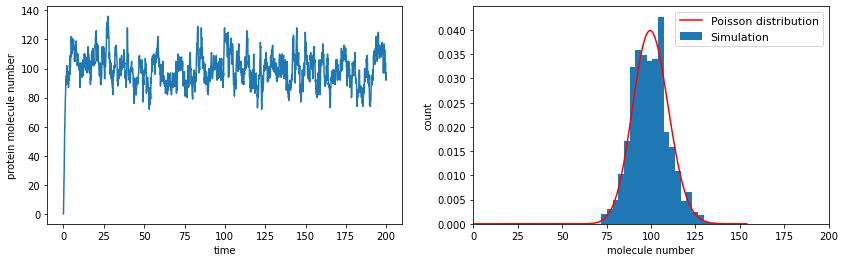

In [6]:
%%capture --no-display

fig, (ax1, ax2) =  plt.subplots(1, 2, figsize = (14, 4))

ax1.plot(t_vec, N_vec, color="tab:blue")
ax1.set_xlabel('time')
ax1.set_ylabel('protein molecule number')

n_vec = np.arange(0, 200)
lam = k_exp/k_deg
poisson = (lam**n_vec/sp.factorial(n_vec))*np.exp(-lam)

ax2.hist(N_vec[100:], bins = 20, density=True, label = "Simulation")
ax2.plot(n_vec, poisson, color = 'red', label = "Poisson distribution")
ax2.set_xlim(0, 200)
ax2.set_xlabel('molecule number')
ax2.set_ylabel('count')
ax2.legend(prop={"size":11})
plt.show()

---

<span style="color:red">

In the first plot we got, we can see that the system reaches a steady state quite fast and in the steady state, it fluctuates around the value of 100 molecules.  
This is shown very nicely in the histogram, where the mean value is exactly 100. The theoretical Poisson distribution (which has $\mu = \frac{100}{1}$) fits well our stochastic simulation.</span>

---

Next, we separate the expression into transcription and translation. We thus have four reactions (transcription, translation, mRNA degradation and protein degradation) and two species (mRNA and protein). Integrate the system of reactions and plot the resulting time series and normalized histograms for the two species. Consider a transcription rate $k_{tx}=10$, a translation rate $k_{tl}=100$, and $k_{deg}=1$.

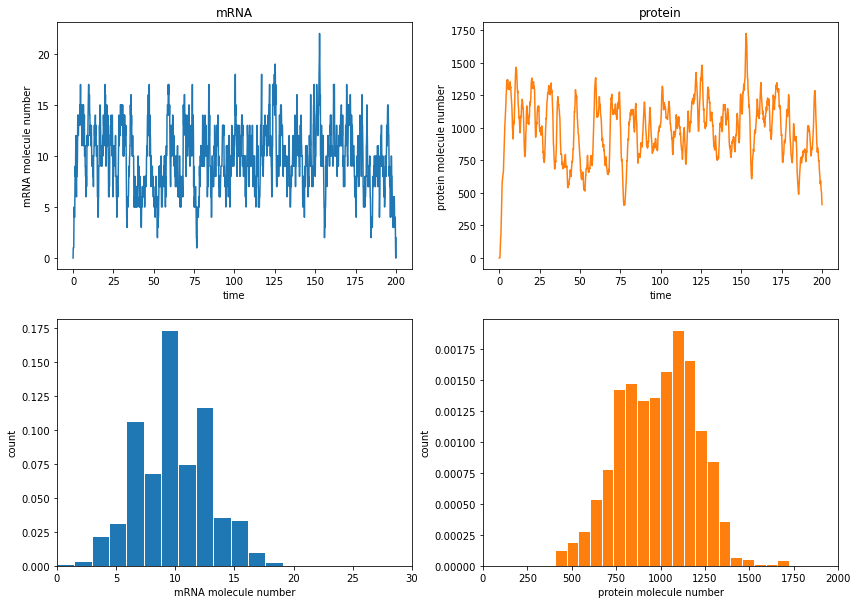

In [7]:
N_RNA_0 = 0
N_prot_0 = 0

k_tx = 10
k_tl = 100
S = np.array([[1, 0, -1, 0], [0, 1, 0, -1]])

a_tx = k_tx

def a_tl(N_RNA):
    return k_tl*N_RNA

def a_deg_RNA(N_RNA):
    return k_deg*N_RNA

def a_deg_prot(N_prot):
    return k_deg*N_prot


def a_tot(N_RNA, N_prot):
    return a_tx + a_tl(N_RNA) + a_deg_RNA(N_RNA) + a_deg_prot(N_prot)


def tao(N_RNA, N_prot):
    z1 = np.random.uniform(0,1)
    return 1/(a_tot(N_RNA, N_prot))*(np.log(1/z1))

def change(N_RNA, N_prot):
    z2 = np.random.uniform(0,1)
    if z2 > (a_tx + a_tl(N_RNA) + a_deg_RNA(N_RNA))/a_tot(N_RNA, N_prot):
        return S[:, 3]
    elif z2 > (a_tx + a_tl(N_RNA))/a_tot(N_RNA, N_prot):
        return S[:, 2]
    elif z2 > a_tx/a_tot(N_RNA, N_prot):
        return S[:, 1]
    else:
        return S[:, 0]
    
def N_new(N_RNA, N_prot):
    change_RNA, change_prot = change(N_RNA, N_prot)
    N_RNA += change_RNA
    N_prot += change_prot
    return N_RNA, N_prot


N_RNA_vec = [N_RNA_0]
N_prot_vec = [N_prot_0]

N_RNA = N_RNA_0
N_prot = N_prot_0
t = t_0
i = 0

while t <= t_max:
    t += tao(N_RNA, N_prot)
    N_RNA, N_prot = N_new(N_RNA, N_prot)
    if t - t_vec[i] >= mt:
        N_RNA_vec.append(N_RNA)
        N_prot_vec.append(N_prot)
        i += 1

fig, ((ax1, ax2), (ax3, ax4)) =  plt.subplots(2, 2, figsize = (14, 10))

ax1.plot(t_vec, N_RNA_vec, color="tab:blue")
ax1.set_title("mRNA")
ax1.set_xlabel('time')
ax1.set_ylabel('mRNA molecule number')

ax3.hist(N_RNA_vec[150:], bins = 15, edgecolor = "white", density = True)
ax3.set_xlim(0, 30)
ax3.set_xlabel('mRNA molecule number')
ax3.set_ylabel('count')

ax2.plot(t_vec, N_prot_vec, color="tab:orange")
ax2.set_title("protein")
ax2.set_xlabel('time')
ax2.set_ylabel('protein molecule number')

ax4.hist(N_prot_vec[150:], bins = 20, edgecolor = "white", color="tab:orange", density = True)
ax4.set_xlim(0, 2000)
ax4.set_xlabel('protein molecule number')
ax4.set_ylabel('count')
plt.show()

---

<span style="color:red">

In this next model, we see that in the steady state, the number of mRNA molecules fluctuates around 10. This is consistent with the value we would expect for the mean of a Poisson distribution ($\frac{k_{tx}}{k_{deg}} = \frac{10}{1}$).  
The distribution for the protein is a bit more complex because it also depends on the number of mRNA molecules, which is variable. However we can see a clear mean of 1000 molecules in the steady state.</span>

---

Finally, scale the transcription and translation rates by the same factor, multiplying one of the rates and dividing the other, in such a way that the product remains constant, and discuss what happens with the mean and standard deviation of the distribution of protein numbers for different values of this factor (smaller and larger than 1).

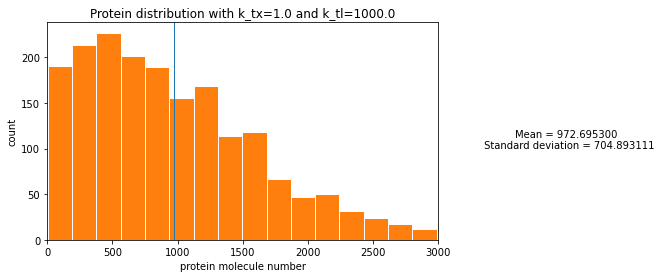

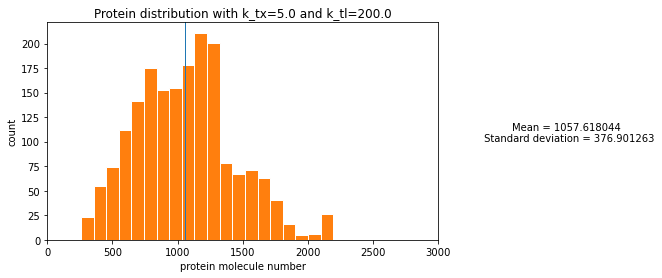

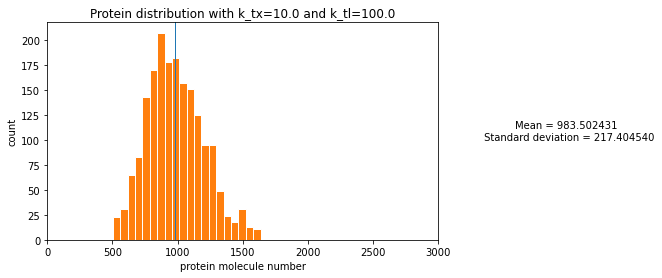

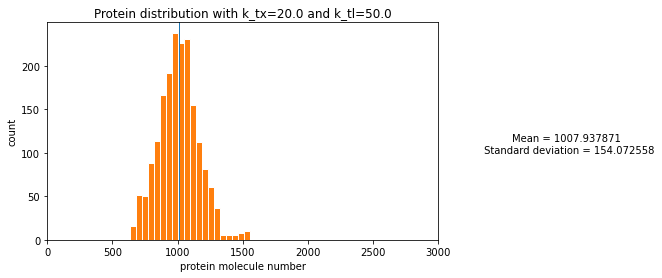

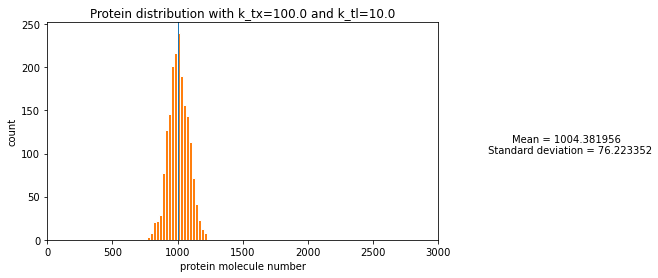

In [8]:
factors = [0.1, 0.5, 1, 2, 10]
for f in factors:
    k_tx = 10
    k_tl = 100
    k_tx = k_tx * f
    k_tl = k_tl / f

    a_tx = k_tx

    N_RNA_vec = [N_RNA_0]
    N_prot_vec = [N_prot_0]
    
    N_RNA = N_RNA_0
    N_prot = N_prot_0
    t = t_0
    i = 0

    while t <= t_max:
        t += tao(N_RNA, N_prot)
        N_RNA, N_prot = N_new(N_RNA, N_prot)
        if t - t_vec[i] >= mt:
            N_RNA_vec.append(N_RNA)
            N_prot_vec.append(N_prot)
            i += 1
    
    plt.figure(figsize = (7, 4))
    plt.title("Protein distribution with k_tx=%.1f and k_tl=%.1f" %(k_tx, k_tl))
    plt.hist(N_prot_vec[150:], bins = 20, edgecolor = "white", color="tab:orange")
    plt.axvline(np.array(N_prot_vec[150:]).mean(), color = "tab:blue", linewidth = 1)
    plt.xlim(0, 3000)
    plt.xlabel('protein molecule number')
    plt.ylabel('count')
    txt = "Mean = %f \n Standard deviation = %f" % (np.array(N_prot_vec[150:]).mean(),
                                                    np.sqrt(np.array(N_prot_vec[150:]).var()))
    plt.text(4000, 100, txt, ha = 'center')
    plt.show()

---

<span style="color:red">

In all of this cases we get a mean value of approximately 1000 molecules. This shows that the mean is not dependent on the single values of $k_{tx}$ and $k_{tl}$, but rather on the product of these two, which in fact stays constant.  
We do see a large change in the variability of the distributions: when $k_{tx}$ is small and $k_{tl}$ is large the standard deviation is larger and when $k_{tx}$ is large and $k_{tl}$ is small the standard deviation is smaller.  
This would be consistent with a **gamma distribution**, where the mean would be $\mu = k_{tx} \cdot k_{tl}$ and the standard deviation would be $\sigma = \sqrt{k_{tx} \cdot k_{tl}^2}$.  
This also shows that we can control the variability of a system without having to change the mean.</span>

---